# 1D Beam–Plasma (Bump-on-Tail) Prototype

This notebook implements a 1D beam–plasma simulation.

Roadmap:

1. Define physical constants and design the beam + background + resonance (set $k$ so that $v_φ = ωₚ / k$ sits on the beam slope).
2. Specify simulation and fitting parameters.
3. Run a **short diagnostic simulation** to quickly estimate a clean linear-growth window and $γ$.
4. Run a **full-quality simulation** with many particles and longer time, while sampling particle velocities.
5. Automatically detect:
   - saturation time t_sat,
   - a late non-linear time $t_{lateNL} ≈ t_{sat} + 8 τ_B$.
6. Build approximate Maxwellian PDFs for the beam at:
   - early linear time (“early”),
   - late linear time (“late-L”),
   - late non-linear time (“late-NL”),
   and compute $Δf(v) = f_{lateNL} − f_{early}$.
7. Plot:
   - $|E|(t)$ with an interactive linear-fit window selector,
   - Beam PDFs and $Δf(v)$ relative to the resonance velocity $v_φ$.


## Imports
We import NumPy for arrays, Matplotlib for plotting, `tqdm` for progress bars,
and `SpanSelector` for interactive window selection on the $|E|(t)$ plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.widgets import SpanSelector
from scipy import special  # reserved for later if we need special functions

%matplotlib widget

import matplotlib
print("Backend:", matplotlib.get_backend())

Backend: widget


## Physical constants
For now we non-dimensionalize so that ωₚ, e, and mₑ are all 1. These can be
rescaled later when we want more realistic units.

In [2]:
# =========================== PHYSICS CONSTANTS =============================
omega_p  = 1.0
e_charge = 1.0
m_e      = 1.0

## Beam and resonance design

We define:
- `ub_target`: beam mean velocity (location of the bump).
- `vb_target`: beam thermal spread (σ of the beam Maxwellian).
- `alpha`: how far to the left of the beam mean we place the phase velocity $v_φ$,
  in units of $σ$ (so $v_φ = u_b − α σ$).

Then we solve for k from v_φ = ωₚ / k and define the domain length L = 2π / k.

In [3]:
# =========================== BEAM & RESONANCE DESIGN =======================
ub_target = 1.20     # beam mean (peak of Maxwellian)
vb_target = 0.30     # beam thermal spread (std)
alpha     = 0.80     # how far left (in sigmas) we want v_phi from the mean; 0<alpha<1

# Phase velocity design: v_phi < ub and within ~1σ
vphi_target = ub_target - alpha * vb_target
k           = omega_p / vphi_target          # so that v_phi = omega_p/k = vphi_target
v_phi       = omega_p / k
L           = 2.0 * np.pi / k

## Background distribution and main simulation parameters

- Background electrons: Maxwellian with zero mean and some width `BG_STD`.
- `PARAMS` collects the main beam parameters used by both short and full runs:
  - `nb_true`: true beam density fraction,
  - `ub`, `vb`: beam mean and thermal spread,
  - `sample_frac_beam`: fraction of simulation particles assigned to the beam,
  - `dt`: time step,
  - `N_total`: base particle count for the short run,
  - `E_amp`: initial field amplitude.

In [4]:
# Background (kept Maxwellian-ish around 0 with moderate width)
BG_STD   = 0.60

# =========================== SIMULATION PARAMETERS =========================
PARAMS = dict(
    nb_true=0.1920,          # true beam density fraction
    ub=ub_target,
    vb=vb_target,
    sample_frac_beam=0.86,   # fraction of particles in the beam
    dt=0.1,
    N_total=1000,            # base N used for short run
    E_amp=4.27e-06,          # initial field amplitude
)

## Run / fit controls

We fix:
- total time for short and full runs,
- controls for the linear-fit algorithm (window sizes, R² threshold),
- sampling cadence for PDFs,
- RNG seed for reproducibility.

In [ ]:
# =========================== RUN / FIT CONTROLS ============================
seed        = 42
tmax_full   = 6000.0       # total time for full-quality run
tmax_short  = 800.0        # total time for short diagnostic run

FIT_BOUNDS  = None         # can be set interactively later
prefer_earliest_window = True
min_pts_for_fit = 40
R2_THRESH   = 0.85
W_list_candidates = [60.0, 80.0, 100.0, 120.0, 240.0]  # candidate fit-window lengths
scan_seconds_short = 2.0
scan_seconds_full  = 2.0

# For the PDF stage sampling windows
halfwin      = 5.0         # half-width around target times for sampling PDFs
sample_every = 8           # sample velocities every N time steps

# RNG
rng = np.random.default_rng(seed)

## Short diagnostic run: idea

We first run a **short, low-N simulation** to:
- quickly see $|E|(t)$,
- automatically detect a good linear-growth window,
- get an estimate of $γ$ and the corresponding [t₀, t₁].

This is cheap and guides the full-quality run.

### Short-run parameter unpacking
We copy the values from `PARAMS` into short-run variables with `_s` suffix.

In [6]:
# =========================== SHORT DIAGNOSTIC RUN ==========================
nb_true_s  = float(PARAMS['nb_true'])
ub_s       = float(PARAMS['ub'])
vb_s       = float(PARAMS['vb'])
sf_s       = float(PARAMS['sample_frac_beam'])
dt_s       = float(PARAMS['dt'])
E_amp_s    = float(PARAMS['E_amp'])
N_total_s  = int(PARAMS['N_total'])

### Short-run particle counts and initial velocities

We decide how many particles belong to the beam vs. the background, then draw:
- beam velocities from N(ub_s, vb_s²),
- background velocities from N(0, BG_STD²).

In [7]:
N_beam_s   = max(1, int(round(sf_s * N_total_s)))
N_bg_s     = N_total_s - N_beam_s

# Initial velocity distribution: beam + background
v_short = np.concatenate([
    ub_s + vb_s * rng.standard_normal(N_beam_s),
    BG_STD * rng.standard_normal(N_bg_s),
])

### Short-run positions and particle weights

- Positions `x_short` are uniform on [0, L).
- Weights `w_short` are chosen so that:
  - the beam contributes a fraction `nb_true_s` of the total density,
  - the background contributes the rest.

In [8]:
# Positions uniformly in [0, L)
x_short = L * rng.random(N_total_s)

# Weights so that beam fraction = nb_true_s
w_short = np.concatenate([
    np.full(N_beam_s, nb_true_s / N_beam_s),
    np.full(N_bg_s,   (1.0 - nb_true_s) / N_bg_s),
])

### Leapfrog initialization (short run)

We use a standard leapfrog:
1. Start from v at t = 0.
2. Compute E-field from particle phases.
3. Take a half-step in v to obtain `vhalf_short` at t = −Δt/2.

This sets up the staggered update for (v, x).

In [9]:
phase0_short = (k * x_short - omega_p * 0.0)
E0_short     = E_amp_s * np.cos(phase0_short)
vhalf_short  = v_short - 0.5 * dt_s * (e_charge / m_e) * E0_short

### Allocate arrays and perform the short diagnostic loop

We allocate arrays to store:
- `E_hist_short`: $|E|(t)$ during the short run,
- `t_hist_short`: corresponding times.

Then we iterate the leapfrog updates:
- update v,
- update x,
- compute current Jₖ,
- update the mode amplitude E.

In [10]:
nsteps_short = max(1, int(round(tmax_short / dt_s)))
E_hist_short = np.empty(nsteps_short, dtype=float)
t_hist_short = np.empty(nsteps_short, dtype=float)
time_short   = 0.0

for step_short in tqdm(range(nsteps_short), desc="Short run", ncols=80):
    # record field amplitude
    E_hist_short[step_short] = abs(E_amp_s)
    t_hist_short[step_short] = time_short

    # field from current particle phases
    phase_short   = (k * x_short - omega_p * time_short)
    E_field_short = E_amp_s * np.cos(phase_short)

    # velocity update (kick)
    vhalf_new_short = vhalf_short - (e_charge / m_e) * E_field_short * dt_s
    v_cent_short    = 0.5 * (vhalf_short + vhalf_new_short)

    # position update (drift)
    x_short = (x_short + vhalf_new_short * dt_s) % L

    # current and field amplitude update
    cos_phase_short = np.cos(k * x_short - omega_p * time_short)
    J_k_short = -e_charge * (np.dot(w_short, v_cent_short * cos_phase_short) / np.sum(w_short))
    E_amp_s   = E_amp_s - (e_charge / (m_e * omega_p)) * J_k_short * dt_s

    vhalf_short = vhalf_new_short
    time_short += dt_s

    # early stop if the field amplitude explodes
    if E_amp_s > 1.0:
        E_hist_short = E_hist_short[:step_short+1]
        t_hist_short = t_hist_short[:step_short+1]
        break

Short run:  17%|████▍                     | 1361/8000 [00:00<00:02, 2997.41it/s]


### Sliding-window linear fit on short run

We:
1. Take $log(|E|)$.
2. Slide a window of length `W_try` over time.
3. For each window, fit `log|E| ≈ γ t + const` by least squares.
4. Accept a window if:
   - R² ≥ `R2_THRESH`,
   - γ > 0,
   - at least some minimum number of points.
5. Optionally pick the earliest such window.

This gives us an initial estimate of γ and a candidate `[t₀, t₁]` for linear growth.

In [11]:
mask_fit_short        = (E_hist_short > 0.0)
t_fit_base_short      = t_hist_short[mask_fit_short]
logE_fit_base_short   = np.log(E_hist_short[mask_fit_short])

fit_short = None
if t_fit_base_short.size >= min_pts_for_fit:
    r2best_short = -np.inf
    if t_fit_base_short.size > 1:
        dt_eff_short = max(1e-9, t_fit_base_short[1] - t_fit_base_short[0])
    else:
        dt_eff_short = 1.0
    step_incr_short = max(1, int(round(scan_seconds_short / dt_eff_short)))

    for W_try in W_list_candidates:
        i0_short = 0
        while (
            i0_short < t_fit_base_short.size
            and (t_fit_base_short[i0_short] + W_try) <= t_fit_base_short[-1]
        ):
            sel_short = (
                (t_fit_base_short >= t_fit_base_short[i0_short]) &
                (t_fit_base_short <= t_fit_base_short[i0_short] + W_try)
            )
            if np.count_nonzero(sel_short) >= 25:
                tt = t_fit_base_short[sel_short]
                yy = logE_fit_base_short[sel_short]
                A  = np.vstack([tt, np.ones_like(tt)]).T
                c  = np.linalg.lstsq(A, yy, rcond=None)[0]
                gamma_try = c[0]
                yhat_try  = A @ c
                ssr = np.sum((yy - yhat_try) ** 2)
                sst = np.sum((yy - np.mean(yy)) ** 2)
                r2  = 1.0 - ssr / max(1e-12, sst)

                if (r2 >= R2_THRESH) and (gamma_try > 0.0):
                    fit_short = dict(
                        gamma=gamma_try, r2=r2,
                        t0=tt[0], t1=tt[-1],
                        twin=tt, yhat=yhat_try,
                    )
                    if prefer_earliest_window:
                        break
            i0_short += step_incr_short
        if fit_short and prefer_earliest_window:
            break

if fit_short:
    print(f"[short] gamma={fit_short['gamma']:.4e}, R^2={fit_short['r2']:.3f}, "
          f"window=[{fit_short['t0']:.0f},{fit_short['t1']:.0f}]")
else:
    print("[short] No clean positive-slope window found")

[short] gamma=2.4616e-02, R^2=0.858, window=[32,132]


## Full-quality run

Now we run a long simulation with many more particles. We will:
- reuse the same physics,
- sample velocities periodically,
- later extract PDFs and Δf(v).

First, we unpack `PARAMS` into full-run variables with `_f` suffix.

In [12]:
# =========================== FULL-QUALITY RUN ==============================
nb_true_f  = float(PARAMS['nb_true'])
ub_f       = float(PARAMS['ub'])
vb_f       = float(PARAMS['vb'])
sf_f       = float(PARAMS['sample_frac_beam'])
dt_f       = float(PARAMS['dt'])
E_amp_f    = float(PARAMS['E_amp'])
N_total_f  = int(PARAMS['N_total'])

### Particle numbers and initial distributions (full run)

We choose:
- a large `N_plot` (at least `N_total_f`),
- beam and background particle counts,
then draw velocities and positions as before.

In [13]:
N_plot     = max(N_total_f, 30000)
N_beam_f   = max(1, int(round(sf_f * N_plot)))
N_bg_f     = N_plot - N_beam_f

# Initial velocities and positions
v_full = np.concatenate([
    ub_f + vb_f * rng.standard_normal(N_beam_f),
    BG_STD * rng.standard_normal(N_bg_f),
])
x_full = L * rng.random(N_plot)

# Weights for beam and background
w_full = np.concatenate([
    np.full(N_beam_f, nb_true_f / N_beam_f),
    np.full(N_bg_f,   (1.0 - nb_true_f) / N_bg_f),
])

idx_beam_full = np.arange(N_beam_f, dtype=int)
idx_bg_full   = np.arange(N_beam_f, N_plot, dtype=int)

### Leapfrog initialization and storage (full run)

We set up the leapfrog half-step velocities and allocate:
- `E_hist_full`, `t_hist_full` to store $|E|(t)$,
- sampling lists for velocities at different times for the beam and background.

In [14]:
# Initialize leapfrog half-step velocities
phase0_full = (k * x_full - omega_p * 0.0)
E0_full     = E_amp_f * np.cos(phase0_full)
vhalf_full  = v_full - 0.5 * dt_f * (e_charge / m_e) * E0_full

nsteps_full = max(1, int(round(tmax_full / dt_f)))
E_hist_full = np.empty(nsteps_full, dtype=float)
t_hist_full = np.empty(nsteps_full, dtype=float)
time_full   = 0.0

# Sampling storage for PDFs (beam + background separated)
v_samps_full        = []
w_samps_full        = []
t_samp_full         = []
v_samps_beam_full   = []
w_samps_beam_full   = []
v_samps_bg_full     = []
w_samps_bg_full     = []

### Full run loop

Each time step:
1. Update velocities and positions using leapfrog.
2. Update the field amplitude from the current.
3. Every `sample_every` steps, store:
   - a random subset of all particles,
   - separate subsets for beam and background (for PDFs).

In [15]:
for step_full in tqdm(range(nsteps_full), desc="Full-quality run", ncols=80):
    # record |E|
    E_hist_full[step_full] = abs(E_amp_f)
    t_hist_full[step_full] = time_full

    # field from current phases
    phase_full   = (k * x_full - omega_p * time_full)
    E_field_full = E_amp_f * np.cos(phase_full)

    # velocity update (kick)
    vhalf_new_full = vhalf_full - (e_charge / m_e) * E_field_full * dt_f
    v_cent_full    = 0.5 * (vhalf_full + vhalf_new_full)

    # position update (drift)
    x_full = (x_full + vhalf_new_full * dt_f) % L

    # sample velocities every 'sample_every' steps
    if (step_full % sample_every) == 0:
        ns = min(20000, v_cent_full.size)
        idx = rng.permutation(v_cent_full.size)[:ns]

        v_samps_full.append(v_cent_full[idx])
        w_samps_full.append(w_full[idx])
        t_samp_full.append(time_full)

        # separate beam / background for PDFs
        idxb = rng.permutation(idx_beam_full.size)[:min(12000, idx_beam_full.size)]
        idxg = rng.permutation(idx_bg_full.size)[:min(12000, idx_bg_full.size)]

        v_samps_beam_full.append(v_cent_full[idx_beam_full[idxb]])
        w_samps_beam_full.append(w_full[idx_beam_full[idxb]])
        v_samps_bg_full.append(v_cent_full[idx_bg_full[idxg]])
        w_samps_bg_full.append(w_full[idx_bg_full[idxg]])

    # update field amplitude from current
    cos_phase_full = np.cos(k * x_full - omega_p * time_full)
    J_k_full = -e_charge * (np.dot(w_full, v_cent_full * cos_phase_full) / np.sum(w_full))
    E_amp_f  = E_amp_f - (e_charge / (m_e * omega_p)) * J_k_full * dt_f

    vhalf_full = vhalf_new_full
    time_full += dt_f

t_samp_full = np.array(t_samp_full)

Full-quality run: 100%|███████████████████| 60000/60000 [15:30<00:00, 64.48it/s]


## Linear fit on full run

We repeat the sliding-window linear fit on `log|E|` for the full run.
Optional `FIT_BOUNDS` can restrict the time interval before fitting.

In [16]:
mask_fit_full = (E_hist_full > 0.0)
t_fit_base_full = t_hist_full[mask_fit_full]
logE_fit_base_full = np.log(E_hist_full[mask_fit_full])

if FIT_BOUNDS is not None:
    lo_b, hi_b = FIT_BOUNDS
    mask_bounds = (t_fit_base_full >= lo_b) & (t_fit_base_full <= hi_b)
    t_fit_base_full    = t_fit_base_full[mask_bounds]
    logE_fit_base_full = logE_fit_base_full[mask_bounds]

fit_full = None
if t_fit_base_full.size >= min_pts_for_fit:
    if t_fit_base_full.size > 1:
        dt_eff_full = max(1e-9, t_fit_base_full[1] - t_fit_base_full[0])
    else:
        dt_eff_full = 1.0
    step_incr_full = max(1, int(round(scan_seconds_full / dt_eff_full)))

    for W_try in W_list_candidates:
        i0_full = 0
        while (
            i0_full < t_fit_base_full.size and
            (t_fit_base_full[i0_full] + W_try) <= t_fit_base_full[-1]
        ):
            sel_full = (
                (t_fit_base_full >= t_fit_base_full[i0_full]) &
                (t_fit_base_full <= t_fit_base_full[i0_full] + W_try)
            )
            if np.count_nonzero(sel_full) >= 25:
                tt = t_fit_base_full[sel_full]
                yy = logE_fit_base_full[sel_full]
                A  = np.vstack([tt, np.ones_like(tt)]).T
                c  = np.linalg.lstsq(A, yy, rcond=None)[0]
                gamma_try = c[0]
                yhat_try  = A @ c
                ssr = np.sum((yy - yhat_try) ** 2)
                sst = np.sum((yy - np.mean(yy)) ** 2)
                r2  = 1.0 - ssr / max(1e-12, sst)

                if (r2 >= R2_THRESH) and (gamma_try > 0.0):
                    fit_full = dict(
                        gamma=gamma_try, r2=r2,
                        t0=tt[0], t1=tt[-1],
                        twin=tt, yhat=yhat_try,
                    )
                    if prefer_earliest_window:
                        break
            i0_full += step_incr_full
        if fit_full and prefer_earliest_window:
            break

if not fit_full:
    print("No clean positive-slope linear window found in the requested bounds.")
else:
    print(f"[full] gamma={fit_full['gamma']:.4e}, R^2={fit_full['r2']:.3f}, "
          f"window=[{fit_full['t0']:.0f},{fit_full['t1']:.0f}]")

[full] gamma=4.9656e-02, R^2=0.861, window=[48,108]


## Sampling windows and concatenation helper

We define a small utility to concatenate sampled velocities and weights over
a list of time-window indices.

In [17]:
def _concat_from_indices(lst_v, lst_w, idxs):
    if idxs.size == 0:
        return np.array([]), np.array([])
    V = np.concatenate([lst_v[i] for i in idxs]) if len(idxs) > 0 else np.array([])
    W = np.concatenate([lst_w[i] for i in idxs]) if len(idxs) > 0 else np.array([])
    return V, W

### Saturation detection and late-NL time

We compute a **local slope** of `log|E|` using a moving window of width `win`.
When the slope stays near 0 for a long enough streak (`SAT_STREAK`), we interpret
that as saturation time `t_sat`.

Then we compute:
- $E_{sat} = |E|(t_{sat})$,
- bounce frequency: $ω_B ≈ √(e k E_{sat} / m)$,
- bounce period: $τ_B = 2π / ω_B$,
- late non-linear time: $t_{lateNL} = t_{sat} + 8 τ_B$ (≈ 8 bounce periods after saturation).

In [18]:
# ---- detect saturation and pick a genuinely late-NL time ----
win    = 60.0                 # seconds for local regression window
dt_eff = t_hist_full[1] - t_hist_full[0]
Wn     = max(5, int(round(win / dt_eff)))

logE   = np.log(np.clip(E_hist_full, 1e-12, None))
slopes = np.full_like(logE, np.nan, dtype=float)
Acol   = np.vstack([np.arange(Wn)*dt_eff, np.ones(Wn)]).T  # local time basis

for i in range(Wn, len(logE)):
    y = logE[i-Wn:i]
    c = np.linalg.lstsq(Acol, y, rcond=None)[0]
    slopes[i] = c[0]  # local d/dt log|E|

# saturation = first time slope magnitude stays small
SLOPE_EPS  = 5e-3
SAT_STREAK = max(5, int(round(40.0 / dt_eff)))  # require ~40 s of small slope
sat_idx    = None
for i in range(Wn, len(slopes) - SAT_STREAK):
    seg = slopes[i:i+SAT_STREAK]
    if np.all(np.isfinite(seg)) and np.all(np.abs(seg) < SLOPE_EPS):
        sat_idx = i
        break

if sat_idx is None:
    # fallback: just take global max E as “near saturation”
    sat_idx = int(np.argmax(E_hist_full))

t_sat = t_hist_full[sat_idx]

# Bounce frequency and late-NL sampling time
E_sat   = abs(E_hist_full[sat_idx])
omega_B = np.sqrt((e_charge * k * E_sat) / m_e) if E_sat > 0 else 0.0
tau_B   = (2*np.pi / omega_B) if omega_B > 0 else 100.0
t_lateNL = t_sat + 8.0 * tau_B   # ~8 bounce periods past saturation

### Choose sampling windows around (early, late-L, late-NL)

We use:
- early reference time: `t_early_ref = t₀` from the linear fit (if available),
- late linear reference: `t_lateL_ref = t₁`,
- late-NL reference: `t_lateNL` from bounce-based estimate.

Around each reference time, we pick all sampling times within ±`halfwin`.

In [19]:
if fit_full:
    t_early_ref = fit_full['t0']
    t_lateL_ref = fit_full['t1']
else:
    t_early_ref = 0.0
    t_lateL_ref = t_sat

early_idx_sel  = np.where(np.abs(t_samp_full - t_early_ref) <= halfwin)[0]
lateL_idx_sel  = np.where(np.abs(t_samp_full - t_lateL_ref) <= halfwin)[0]
lateNL_idx_sel = np.where(np.abs(t_samp_full - t_lateNL) <= halfwin)[0]

print(f"[windows] t_sat≈{t_sat:.1f}, tau_B≈{tau_B:.1f}, lateNL at t≈{t_lateNL:.1f}")
print(f"   early samples  : {len(early_idx_sel)} windows")
print(f"   late-L samples : {len(lateL_idx_sel)} windows")
print(f"   late-NL samples: {len(lateNL_idx_sel)} windows")

# concatenate beam samples for PDFs
vb0_all,  wb0_all  = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, early_idx_sel)
vbL_all,  wbL_all  = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, lateL_idx_sel)
vbNL_all, wbNL_all = _concat_from_indices(v_samps_beam_full, w_samps_beam_full, lateNL_idx_sel)

[windows] t_sat≈467.6, tau_B≈0.3, lateNL at t≈470.1
   early samples  : 13 windows
   late-L samples : 13 windows
   late-NL samples: 12 windows


## Maxwellian fits for the beam

We approximate the beam at each stage (early, late-L, late-NL) by a Gaussian
with:
- mean $μ = ⟨v⟩$,
- standard deviation $σ = √⟨(v − μ)²⟩$,

computed using the particle weights. Then we evaluate these Gaussians on a
common velocity grid to define f_early, f_lateL, and f_lateNL.

In [20]:
def _weighted_moments(v, w):
    """Return (mu, sigma) using normalized weights w."""
    if v.size == 0:
        return np.nan, np.nan
    w = w / max(np.finfo(float).eps, np.sum(w))
    mu = np.sum(w * v)
    s2 = np.sum(w * (v - mu)**2)
    return mu, np.sqrt(max(s2, 0.0))

def _gaussian_pdf(vg, mu, sigma):
    sigma = max(sigma, 1e-6)
    return np.exp(-0.5*((vg-mu)/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

### Compute Gaussian parameters and set a velocity grid

We:
1. Compute $(μ, σ)$ for early, late-L, late-NL using the beam samples.
2. Fall back to $(u_b, v_b)$ if we don't have finite values.
3. Build a velocity grid that spans several $σ$ around all three means plus $v_φ$.

In [21]:
# use sample moments if available; otherwise fall back to PARAMS
mu0, s0 = _weighted_moments(vb0_all,  wb0_all)
muL, sL = _weighted_moments(vbL_all,  wbL_all)
muN, sN = _weighted_moments(vbNL_all, wbNL_all)

if not np.isfinite(mu0): mu0, s0 = ub_f, vb_f
if not np.isfinite(muL): muL, sL = ub_f, vb_f
if not np.isfinite(muN): muN, sN = ub_f, vb_f

print("mu0, s0 =", mu0, s0)
print("muL, sL =", muL, sL)
print("muN, sN =", muN, sN)
print("v_phi   =", v_phi)

# NEW: cap sigmas for plotting so one crazy stage doesn't blow the axis
sigma_plot_cap = 5.0  # max sigma we'll let control the axis (tunable)

def _sigma_for_plot(s, fallback):
    if not np.isfinite(s):
        return fallback
    return min(s, sigma_plot_cap)

s0_plot = _sigma_for_plot(s0, vb_f)
sL_plot = _sigma_for_plot(sL, vb_f)
sN_plot = _sigma_for_plot(sN, vb_f)

sigma_max_for_grid = max(s0_plot, sL_plot, sN_plot, vb_f)

mu_min = min(mu0, muL, muN, v_phi)
mu_max = max(mu0, muL, muN, v_phi)

vg_min = mu_min - 4.0 * sigma_max_for_grid
vg_max = mu_max + 4.0 * sigma_max_for_grid

vg_grid = np.linspace(vg_min, vg_max, 900)

# Maxwellian PDFs using the true (unclipped) sigmas
pdf_early_beam  = _gaussian_pdf(vg_grid, mu0, s0)
pdf_lateL_beam  = _gaussian_pdf(vg_grid, muL, sL)
pdf_lateNL_beam = _gaussian_pdf(vg_grid, muN, sN)


mu0, s0 = 1.1783977541429298 0.3228796089265153
muL, sL = 1.12199992534403 0.37499811719442977
muN, sN = -2.865230779411748 287.4952357153103
v_phi   = 0.96


## Plot |E|(t) with interactive linear fit

We plot $|E|(t)$ on a semilog scale and attach a `SpanSelector` so that:
- dragging with the mouse selects a time window [t₀, t₁],
- the code fits $log|E|$ in that window,
- it overlays the fit and prints γ and R²,
- pressing **S** saves the chosen window as `FIT_BOUNDS`,
- pressing **R** resets the selection.

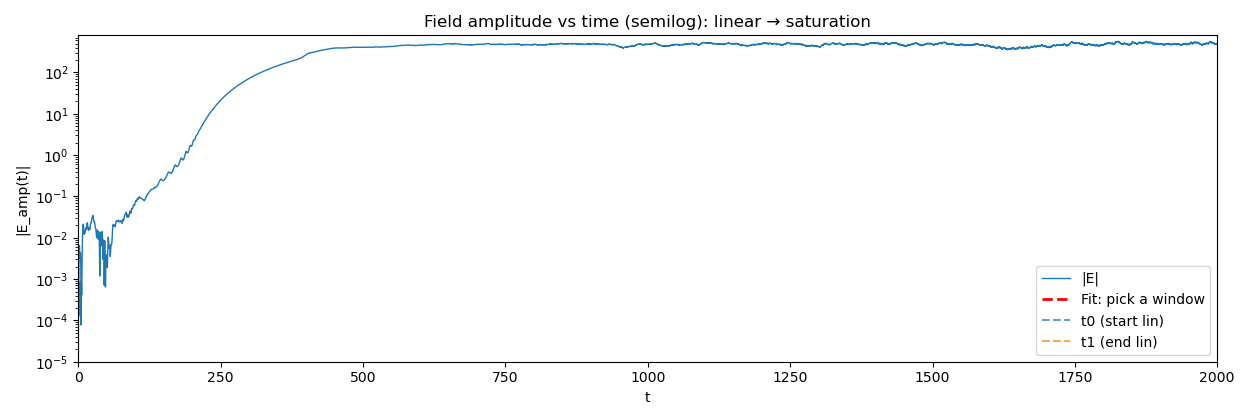

In [22]:
mask_fit_full        = (E_hist_full > 0.0)
t_fit_base_full      = t_hist_full[mask_fit_full]
logE_fit_base_full   = np.log(E_hist_full[mask_fit_full])

figA = plt.figure(figsize=(12.5, 4.2))
axA  = figA.add_subplot(1, 1, 1)

# main curve
lineE, = axA.semilogy(t_hist_full, E_hist_full, lw=1.0, label='|E|')
axA.set_ylim(1e-5, 1.2*np.max(E_hist_full))
axA.set_xlim(0, 2000)
axA.set_title('Field amplitude vs time (semilog): linear → saturation')
axA.set_xlabel('t')
axA.set_ylabel('|E_amp(t)|')

# Placeholders that will be updated by interactions
fit_line, = axA.semilogy([], [], 'r--', lw=2.0, label='Fit: pick a window')
v_t0 = axA.axvline(np.nan, ls='--', color='tab:blue',   alpha=0.7, label='t0 (start lin)')
v_t1 = axA.axvline(np.nan, ls='--', color='tab:orange', alpha=0.7, label='t1 (end lin)')
leg  = axA.legend(loc='best')

# State to carry results out of the callback
gamma_fit = None
r2_fit    = None
t0_sel    = None
t1_sel    = None

def _update_legend_text(gamma, r2):
    fit_label = (
        f"Fit: γ={gamma:.3e}, R²={r2:.3f}"
        if (gamma is not None) else
        "Fit: pick a window"
    )
    fit_line.set_label(fit_label)
    axA.legend_.remove()
    axA.legend(loc='best')

def _do_fit(t0, t1):
    global gamma_fit, r2_fit, t0_sel, t1_sel
    if t0 > t1:
        t0, t1 = t1, t0

    sel = (t_fit_base_full >= t0) & (t_fit_base_full <= t1)
    if np.count_nonzero(sel) < 5:
        gamma_fit = r2_fit = None
        _update_legend_text(None, None)
        fit_line.set_data([], [])
        v_t0.set_xdata([np.nan, np.nan])
        v_t1.set_xdata([np.nan, np.nan])
        figA.canvas.draw_idle()
        return

    tt = t_fit_base_full[sel]
    yy = logE_fit_base_full[sel]
    A  = np.vstack([tt, np.ones_like(tt)]).T
    c  = np.linalg.lstsq(A, yy, rcond=None)[0]

    gamma = c[0]
    yhat  = A @ c
    ssr   = np.sum((yy - yhat) ** 2)
    sst   = np.sum((yy - np.mean(yy)) ** 2)
    r2    = 1.0 - ssr / max(1e-12, sst)

    # Update visuals
    fit_line.set_data(tt, np.exp(yhat))
    v_t0.set_xdata([t0, t0])
    v_t1.set_xdata([t1, t1])
    _update_legend_text(gamma, r2)

    gamma_fit, r2_fit, t0_sel, t1_sel = float(gamma), float(r2), float(t0), float(t1)
    figA.canvas.draw_idle()

# SpanSelector for mouse drag to choose [t0, t1]
span = SpanSelector(
    axA, onselect=_do_fit, direction='horizontal',
    useblit=True, props=dict(alpha=0.2), interactive=True
)

def _on_key(event):
    global FIT_BOUNDS
    if event.key in ('r', 'R'):
        # reset visuals/state
        fit_line.set_data([], [])
        v_t0.set_xdata([np.nan, np.nan])
        v_t1.set_xdata([np.nan, np.nan])
        _update_legend_text(None, None)
        figA.canvas.draw_idle()
        print("[interactive] Reset.")
    if event.key in ('s', 'S'):
        if (t0_sel is not None) and (t1_sel is not None) and (gamma_fit is not None):
            FIT_BOUNDS = (float(min(t0_sel, t1_sel)), float(max(t0_sel, t1_sel)))
            print(f"[interactive] Saved: FIT_BOUNDS={FIT_BOUNDS}, "
                  f"gamma={gamma_fit:.6e}, R2={r2_fit:.3f}")
        else:
            print("[interactive] Nothing to save — pick a window first.")

figA.canvas.mpl_connect('key_press_event', _on_key)
figA.tight_layout()

plt.show()

## Beam PDFs and Δf(v)

Finally we plot:
- Early and late-linear beam Maxwellians on the left,
- $Δf(v) = f_{lateNL} − f_{early}$ on the right,
and mark the phase velocity v_φ with a vertical line to see how the depletion/
pile-up aligns with the resonance.

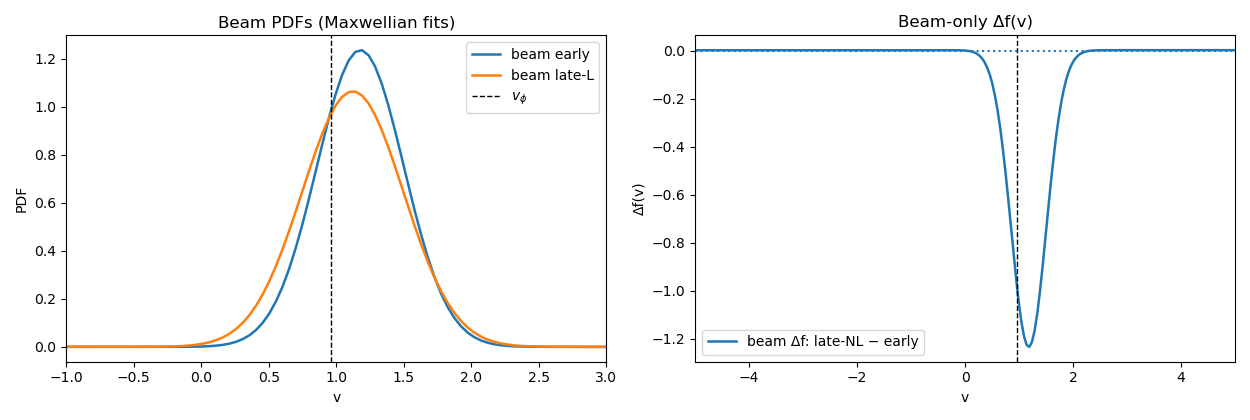

In [23]:
figC = plt.figure(figsize=(12.5, 4.2))

# Left panel: early vs late-linear Maxwellians
axC1 = figC.add_subplot(1, 2, 1)
axC1.plot(vg_grid, pdf_early_beam, lw=1.8, label='beam early')
axC1.plot(vg_grid, pdf_lateL_beam, lw=1.8, label='beam late-L')
axC1.axvline(v_phi, ls='--', color='k', lw=1.0, label=r'$v_\phi$')  # true phase velocity
axC1.set_xlim(-1,3) #(vg_min, vg_max)
axC1.set_xlabel('v')
axC1.set_ylabel('PDF')
axC1.set_title('Beam PDFs (Maxwellian fits)')
axC1.legend(loc='best')

# Right panel: Δf(v) = f_lateNL − f_early
axC2 = figC.add_subplot(1, 2, 2)
axC2.plot(vg_grid, pdf_lateNL_beam - pdf_early_beam, lw=1.8,
          label='beam Δf: late-NL − early')
axC2.axvline(v_phi, ls='--', color='k', lw=1.0)
axC2.axhline(0.0, ls=':')
axC2.set_xlim(-5,5) #(vg_min, vg_max)
axC2.set_xlabel('v')
axC2.set_ylabel('Δf(v)')
axC2.set_title('Beam-only Δf(v)')
axC2.legend(loc='best')

figC.tight_layout()
plt.show()

## Linear kinetic growth rate from the 2-Maxwellian dispersion relation

Instead of using a beam-only Landau estimate, we now compute the
linear growth rate $\gamma$ from the full kinetic dispersion relation for a
two-component electron plasma (background + beam), both modeled as
Maxwellians with the same parameters used in the simulation:

- background: density $n_{\text{bg}} = 1 - n_b$, mean 0, width `BG_STD`
- beam: density $n_b$, mean `ub`, width `vb`

The dielectric function is

$$
\varepsilon(\omega,k) = 1 + \chi_{\text{bg}} + \chi_{\text{b}},
$$

with

$$
\chi_j = \frac{\omega_{pj}^2}{k^2 v_{tj}^2}
\left[1 + \xi_j Z(\xi_j)\right],
\qquad
\xi_j = \frac{\omega/k - u_j}{v_{tj}},
$$

and $Z(\xi)$ the plasma dispersion function.

We take $\omega_{p,j}^2 \propto n_j$ in normalized units, so

- $\omega_{p,\text{bg}}^2 = 1 - n_b$
- $\omega_{p,\text{b}}^2 = n_b$

We then solve $\varepsilon(\omega,k) = 0$ for
$\omega = \omega_r + i\gamma$ near $\omega \approx \omega_p$, and
compare $\gamma$ to the value fitted from the exponential growth of $|E(t)|$.

In [44]:
def Z_plasma(xi):
    return 1j * np.sqrt(np.pi) * special.wofz(xi)

def epsilon_two_maxwellians(omega):
    n_b  = nb_true_f
    n_bg = 1.0 - nb_true_f

    wp_bg2 = n_bg
    wp_b2  = n_b

    vt_bg = BG_STD * np.sqrt(2.0)
    vt_b  = vb_f * np.sqrt(2.0)

    vph = omega / k

    xi_bg = (vph - 0.0) / vt_bg
    xi_b  = (vph - ub_f) / vt_b

    chi_bg = wp_bg2 / (k**2 * vt_bg**2) * (1.0 + xi_bg * Z_plasma(xi_bg))
    chi_b  = wp_b2  / (k**2 * vt_b**2)  * (1.0 + xi_b  * Z_plasma(xi_b))

    return 1.0 + chi_bg + chi_b

def solve_dispersion(omega_init, max_iter=50, tol=1e-10):
    omega = omega_init
    for it in range(max_iter):
        f  = epsilon_two_maxwellians(omega)
        h  = 1e-5
        fp = (epsilon_two_maxwellians(omega + h) -
              epsilon_two_maxwellians(omega - h)) / (2.0 * h)
        omega_new = omega - f / fp
        if abs(omega_new - omega) < tol:
            return omega_new, it + 1
        omega = omega_new
    return omega, max_iter

omega_guess = 1.0 + 0.05j
omega_root, iters = solve_dispersion(omega_guess)

omega_r      = omega_root.real
gamma_theory = omega_root.imag
gamma_fit    = fit_full['gamma'] if fit_full is not None else np.nan

print("=== Kinetic dispersion relation: 2-Maxwellian model ===")
print(f"k                = {k:.4f}")
print(f"nb_true          = {nb_true_f:.4f}")
print(f"BG_STD, vb       = {BG_STD:.4f}, {vb_f:.4f}")
print(f"Dispersion root  = ω = {omega_r:.6f} + i {gamma_theory:.6f}")
print(f"  (converged in {iters} iterations)")
print()
print("=== Linear growth rate comparison ===")
print(f"gamma_theory (DR) = {gamma_theory:.4e}")
print(f"gamma_fit (full)  = {gamma_fit:.4e}")
print(f"ratio fit/theory  = {gamma_fit/gamma_theory:.3f}")

=== Kinetic dispersion relation: 2-Maxwellian model ===
k                = 1.0417
nb_true          = 0.1920
BG_STD, vb       = 0.6000, 0.3000
Dispersion root  = ω = nan + i nan
  (converged in 50 iterations)

=== Linear growth rate comparison ===
gamma_theory (DR) = nan
gamma_fit (full)  = 4.9656e-02
ratio fit/theory  = nan


C:\Users\swany\AppData\Local\Temp\ipykernel_13580\3818831163.py:31: RuntimeWarning: invalid value encountered in scalar divide
  omega_new = omega - f / fp


In [45]:
def run_short_gamma_fixed(N_total, dt, t0, t1, tmax=800.0, seed=42):
    rng_local = np.random.default_rng(seed)

    nb_true = float(PARAMS['nb_true'])
    ub      = float(PARAMS['ub'])
    vb      = float(PARAMS['vb'])
    sf      = float(PARAMS['sample_frac_beam'])
    E_amp0  = float(PARAMS['E_amp'])

    N_total = int(N_total)
    N_beam  = max(1, int(round(sf * N_total)))
    N_bg    = N_total - N_beam

    v = np.concatenate([
        ub + vb * rng_local.standard_normal(N_beam),
        BG_STD * rng_local.standard_normal(N_bg),
    ])
    x = L * rng_local.random(N_total)

    w = np.concatenate([
        np.full(N_beam, nb_true / N_beam),
        np.full(N_bg,   (1.0 - nb_true) / N_bg),
    ])

    phase0 = k * x - omega_p * 0.0
    E_amp  = E_amp0
    E0     = E_amp * np.cos(phase0)

    vhalf = v - 0.5 * dt * (e_charge / m_e) * E0

    nsteps = max(1, int(round(tmax / dt)))
    E_hist = np.empty(nsteps, dtype=float)
    t_hist = np.empty(nsteps, dtype=float)
    time   = 0.0

    for step in range(nsteps):
        E_hist[step] = abs(E_amp)
        t_hist[step] = time

        phase   = k * x - omega_p * time
        E_field = E_amp * np.cos(phase)

        vhalf_new = vhalf - (e_charge / m_e) * E_field * dt
        v_cent    = 0.5 * (vhalf + vhalf_new)

        x = (x + vhalf_new * dt) % L

        cos_phase = np.cos(k * x - omega_p * time)
        J_k       = -e_charge * (np.dot(w, v_cent * cos_phase) / np.sum(w))
        E_amp     = E_amp - (e_charge / (m_e * omega_p)) * J_k * dt

        vhalf = vhalf_new
        time += dt

        if E_amp > 1.0:
            E_hist = E_hist[:step+1]
            t_hist = t_hist[:step+1]
            break

    mask_fit = (E_hist > 0.0)
    t_base   = t_hist[mask_fit]
    logE     = np.log(E_hist[mask_fit])

    sel = (t_base >= t0) & (t_base <= t1)
    if np.count_nonzero(sel) < 8:
        return np.nan, np.nan, None

    tt = t_base[sel]
    yy = logE[sel]
    A  = np.vstack([tt, np.ones_like(tt)]).T
    c  = np.linalg.lstsq(A, yy, rcond=None)[0]
    gamma = c[0]
    yhat  = A @ c
    ssr   = np.sum((yy - yhat)**2)
    sst   = np.sum((yy - np.mean(yy))**2)
    r2    = 1.0 - ssr / max(1e-12, sst)

    info = dict(gamma=gamma, r2=r2, t0=t0, t1=t1, dt=dt, N_total=N_total)
    return gamma, r2, info


N = 500
   (no clean linear fit; skipping)
N = 1000
   (no clean linear fit; skipping)
N = 2000
   gamma = 3.9028e-02, R2 = 0.940
N = 4000
   gamma = 3.0162e-02, R2 = 0.949
N = 8000
   (no clean linear fit; skipping)
N = 16000
   gamma = nan, R2 = nan
N=500: gamma_mean=4.3172e-02 ± 1.2e-03
N=1000: gamma_mean=3.3003e-02 ± 8.7e-03
N=2000: gamma_mean=3.7558e-02 ± 6.7e-03
N=4000: gamma_mean=3.9478e-02 ± 4.1e-03
N=8000: gamma_mean=3.3148e-02 ± 6.7e-03
N=16000: gamma_mean=3.4254e-02 ± 1.9e-03


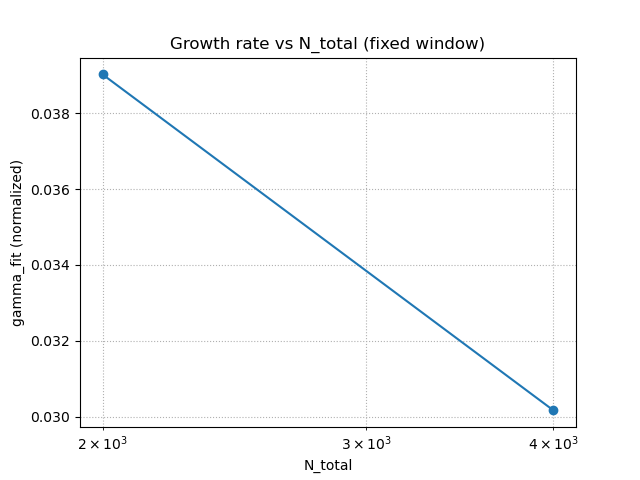

In [46]:
t0_ref, t1_ref = 125.0, 260.0

R2_MIN = 0.85   # or 0.85 if you want to be a bit more generous

if r2 < R2_MIN:
    gamma = np.nan


N_list   = [500, 1000, 2000, 4000, 8000, 16000]
gamma_N  = []
r2_N     = []

for N in N_list:
    print(f"N = {N}")
    g, r2, info = run_short_gamma_fixed(N, dt=PARAMS['dt'],
                                        t0=t0_ref, t1=t1_ref,
                                        tmax=tmax_short, seed=seed)
    if (r2 is None) or (r2 < 0.9):
        print("   (no clean linear fit; skipping)")
        g = np.nan
    else:
        print(f"   gamma = {g:.4e}, R2 = {r2:.3f}")
    gamma_N.append(g)
    r2_N.append(r2)

def gamma_mean_std_N(N_total, dt, t0, t1, n_seeds=5):
    gs = []
    for s in range(n_seeds):
        g, r2, _ = run_short_gamma_fixed(N_total, dt, t0, t1,
                                         tmax=tmax_short, seed=s)
        if (r2 is not None) and (r2 >= 0.9) and np.isfinite(g):
            gs.append(g)
    if len(gs) == 0:
        return np.nan, np.nan
    gs = np.array(gs)
    return gs.mean(), gs.std()

gamma_mean = []
gamma_err  = []

for N in N_list:
    gm, gs = gamma_mean_std_N(N, dt=PARAMS['dt'],
                              t0=t0_ref, t1=t1_ref, n_seeds=5)
    gamma_mean.append(gm)
    gamma_err.append(gs)
    print(f"N={N}: gamma_mean={gm:.4e} ± {gs:.1e}")

plt.figure()
plt.plot(N_list, gamma_N, marker='o')
plt.xscale('log')
plt.xlabel('N_total')
plt.ylabel('gamma_fit (normalized)')
plt.title('Growth rate vs N_total (fixed window)')
plt.grid(True, which='both', ls=':')
plt.show()


=== Kinetic dispersion relation: 2-Maxwellian model === 
k = 1.0417 
nb_true = 0.1000 
BG_STD, vb = 0.6000, 0.3000 
Dispersion root = ω = 0.913381 + i -0.036436 
(converged in 6 iterations) 

=== Linear growth rate comparison === 
gamma_theory (DR) = 3.6436e-02 
gamma_fit (full) = 1.9321e-02 
ratio fit/theory = 0.530



# Next steps
- Gamma values vs number of particles
- Gamma values vs time steps (dt)
- Check the dimensions of gamma and see if it checks with the theoretical